# Assignment 1



Mubaraq Odumeso|
A20614610 |
CS580 |
Spring 2026

## starter code (svar)

[Linear baseline | 10-fold CV] RMSE=0.2422±0.0509MAE=0.1755±0.0380R2=0.0589±0.2588
[Poly deg=2 | 10-fold CV] RMSE=0.1988±0.0227MAE=0.1546±0.0191R2=0.2726±0.4293
[Poly deg=3 | 10-fold CV] RMSE=0.1432±0.0201MAE=0.1133±0.0192R2=0.6092±0.2639
[Poly deg=4 | 10-fold CV] RMSE=0.1068±0.0239MAE=0.0871±0.0232R2=0.7994±0.1070
[Poly deg=5 | 10-fold CV] RMSE=0.1058±0.0257MAE=0.0859±0.0233R2=0.8119±0.0828
[Poly deg=6 | 10-fold CV] RMSE=0.1058±0.0243MAE=0.0873±0.0224R2=0.8119±0.0815
[Poly deg=7 | 10-fold CV] RMSE=0.0786±0.0147MAE=0.0652±0.0127R2=0.8879±0.0684
[Poly deg=8 | 10-fold CV] RMSE=0.0644±0.0139MAE=0.0507±0.0105R2=0.9300±0.0307
[Poly deg=9 | 10-fold CV] RMSE=0.0605±0.0116MAE=0.0485±0.0096R2=0.9357±0.0340
[Poly deg=10 | 10-fold CV] RMSE=0.0539±0.0119MAE=0.0426±0.0102R2=0.9509±0.0228
[Degree selection] Best degree = 10


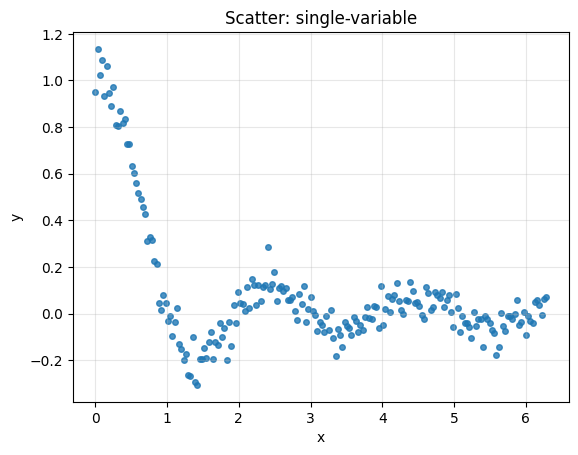

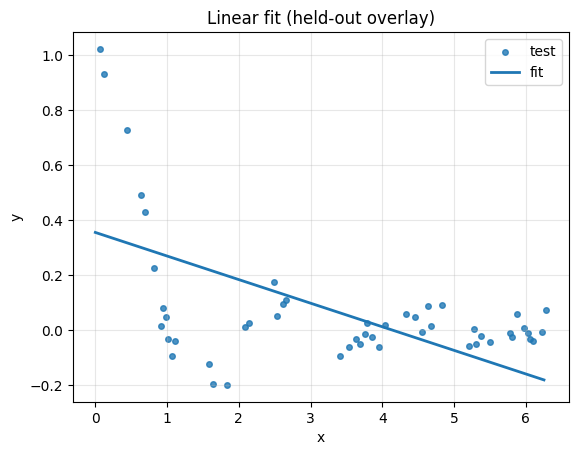

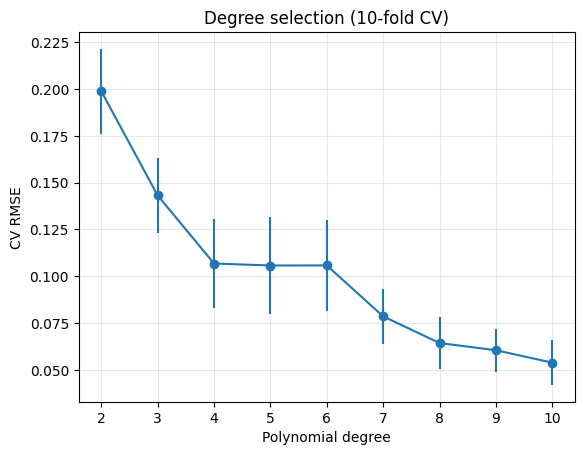

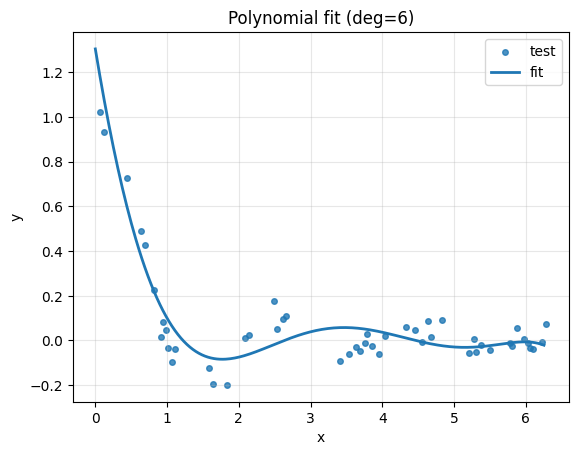

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
DATA_PATH = Path("data") / "svar-set2.csv"
OUTDIR = Path("out_q1_simple")
POLY_DEG = 6
SEED = 42
OUTDIR.mkdir (parents=True, exist_ok=True)
def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)))
rmse_scorer = make_scorer(lambda yt, yp: -rmse(yt, yp))
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)
def load_txt_dataset(path: str):

    arr = np.loadtxt(path, delimiter = ',')
    X, y = arr[:, :-1], arr[:, -1]
    return X, y
def print_cv(model, X, y, k=10, seed=42, label="model"):
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    rmse_scores = -cross_val_score(model, X, y, scoring=rmse_scorer, cv=kf)
    mae_scores = -cross_val_score(model, X, y, scoring=mae_scorer, cv=kf)

    r2_scores = cross_val_score(model, X, y, scoring=r2_scorer, cv=kf)
    print(f"[{label} | {k}-fold CV] "
        f"RMSE={rmse_scores.mean():.4f}±{rmse_scores.std():.4f}"
        f"MAE={mae_scores.mean():.4f}±{mae_scores.std():.4f}"
        f"R2={r2_scores.mean():.4f}±{r2_scores.std():.4f}")
    return rmse_scores.mean(), rmse_scores.std()
def overlay_plot(Xtr, ytr, Xte, yte, model, outpath, title):
    model.fit(Xtr, ytr)
    xs = np.linspace(Xtr.min(), Xtr.max(), 300).reshape(-1, 1)
    ycurve = model.predict(xs)
    plt.figure()
    plt.scatter(Xte, yte, s=16, alpha=0.8, label="test")
    plt.plot(xs, ycurve, lw=2, label="fit")
    plt.xlabel("x"); plt.ylabel("y");
    plt.grid(alpha=0.3); plt.legend()
    plt.title(title)
    plt.savefig(outpath, bbox_inches="tight")


def main():
    X, y = load_txt_dataset (DATA_PATH)
    assert X.shape[1] == 1, "Single-feature dataset expected"
    plt.figure()
    plt.scatter(X, y, s=16, alpha=0.8)
    plt.xlabel("x"); plt.ylabel("y"); plt.title("Scatter: single-variable")
    plt.grid(alpha=0.3)
    plt.savefig(OUTDIR / "01_scatter.png", bbox_inches="tight")
    # 2) Linear regression (baseline)
    linear_pipeline = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("linreg", LinearRegression())
        ])
        
    print_cv(linear_pipeline, X, y, k=10, seed=SEED, label="Linear baseline")
    # Overlay linear fit
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=SEED)
    overlay_plot(Xtr, ytr, Xte, yte, linear_pipeline,
                OUTDIR / "02_overlay_linear.png",
                title="Linear fit (held-out overlay)")
    # 3-4) Polynomial degree selection
    degrees = list(range(2, 11)) 
    means, stds = [], []
    for d in degrees:
        poly_pipeline = Pipeline([
            ("scaler", StandardScaler (with_mean=True, with_std=True)),
            ("poly", PolynomialFeatures (degree=d, include_bias=False)),
            ("linreg", LinearRegression())
        ])
        m, s = print_cv(poly_pipeline, X, y, k=10, seed=SEED, label=f"Poly deg={d}")
        means.append(m); stds.append(s)
    plt.figure()
    plt.errorbar (degrees, means, yerr=stds, marker="o")
    plt.xlabel("Polynomial degree"); plt.ylabel("CV RMSE")
    plt.title("Degree selection (10-fold CV)")
    plt.grid(alpha=0.3)
    plt.savefig(OUTDIR / "03_cv_degree.png", bbox_inches="tight")
    best_deg = degrees [int(np.argmin(means))]
    print(f"[Degree selection] Best degree = {best_deg}")
    # Overlay polynomial fit with chosen POLY_DEG
    best_poly = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("poly", PolynomialFeatures (degree=POLY_DEG, include_bias=False)),
        ("linreg", LinearRegression())
    ])
    
    overlay_plot(Xtr, ytr, Xte, yte, best_poly,
                OUTDIR / f"04_overlay_poly_deg{POLY_DEG}.png",
                title=f"Polynomial fit (deg={POLY_DEG})")
if __name__ == "__main__":
    main()
    
    

## Part 1

### 1.1

**Dataset: svar-set1**
- **Complexity:** The data appears to follow a linear trend. A polynomial of degree 6 will likely fit it best.
- **Noise:** There is a moderate amount of noise.

**Dataset: svar-set2**
- **Complexity:** The data appears to follow a polynomial trend. A polynomial of degree 10 will likely fit it best.
- **Noise:** The noise level is high.

**Dataset: svar-set3**
- **Complexity:** The data appears to follow a polynomial trend. A polynomial of degree 10 will likely fit it best.
- **Noise:** The noise is high, with some clustering in the distribution.

**Dataset: svar-set4**
- **Complexity:** The data appears to follow a polynomial trend. A polynomial of degree 10 will likely fit it best.
- **Noise:** The noise level is high.

### 1.2

In [2]:
def add_bias(X_tr, X_te):
    
    X_tr_bias = np.c_[np.ones((X_tr.shape[0],1)), X_tr]
    X_te_bias = np.c_[np.ones((X_te.shape[0],1)), X_te]
    return X_tr_bias, X_te_bias


In [3]:


X, y = load_txt_dataset(path = DATA_PATH)
X_tr, X_te, y_tr, y_te  = train_test_split(X, y, test_size=0.25, random_state=SEED)

X_tr_bias,  X_te_bias= add_bias(X_tr, X_te)



**NORMAL EQUATION**

In [4]:



   
def solve_normal_equations(X, y, ridge=0.0):
    n_features = X.shape[1]
    A = X.T @ X + ridge * np.eye(n_features)
    b = X.T @ y
    theta = np.linalg.solve(A, b)
    return theta
ne_weights = solve_normal_equations(X_tr_bias, y_tr)
y_hat = X_te_bias @ ne_weights





**GRADIENT DESCENT**

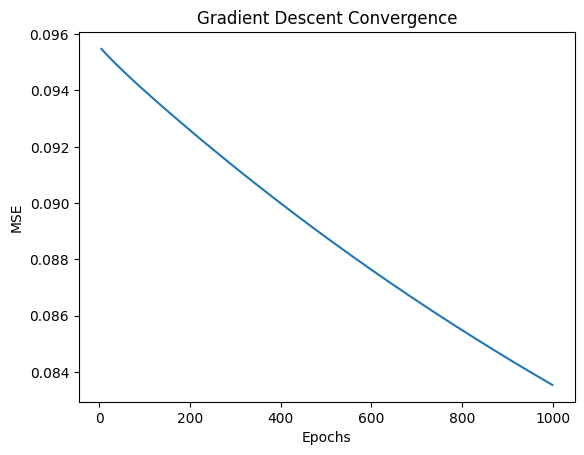

In [5]:

def solve_gradient_descent(X, y, lr = 0.001, epochs =1000): #lr: learning rate, epochs: no. of loops
    n = len(y)
    theta = np.zeros(X.shape[1])
    mse_history=[]
    
    for _ in range(epochs):
       
        y_hat = X @ theta # using this instead of y_hat = X(b) + a because it works better for multiple features
        error = y_hat - y
        
        gradient = 1/n * (X.T @ error)       
        theta = theta - (lr * gradient)
        
        current_mse = np.mean(error**2)
        mse_history.append(current_mse)
        
  
    return theta, mse_history
weights_gd, history = solve_gradient_descent(X_tr_bias, y_tr, epochs=1000 )


plt.plot(range(5, 1000), history[5:])
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Gradient Descent Convergence")
plt.show()

### 1.3
**evaluation**

#### PLOT OVERLAY

In [6]:
def plot_overlay(Xtr, ytr, Xte, yte, weights, train_means=None, train_stds=None, poly_deg=None, title="Overlay fit", label="fit"):
    Xtr = np.asarray(Xtr); Xte = np.asarray(Xte)
    ytr = np.asarray(ytr); yte = np.asarray(yte)
    if Xtr.ndim == 1: Xtr = Xtr.reshape(-1, 1)
    if Xte.ndim == 1: Xte = Xte.reshape(-1, 1)

    if train_means is not None and train_stds is not None:
        
        mean0 = np.asarray(train_means)[0]
        std0  = np.asarray(train_stds)[0] if np.asarray(train_stds).shape[0] > 0 else 1.0
        std0 = std0 if std0 != 0 else 1.0
        Xtr_raw = Xtr[:, 0] * std0 + mean0
        Xte_raw = Xte[:, 0] * std0 + mean0
    else:
        Xtr_raw = Xtr[:, 0]
        Xte_raw = Xte[:, 0]

    x_min, x_max = Xtr_raw.min(), Xtr_raw.max()
    x_min = min(x_min, Xte_raw.min()); x_max = max(x_max, Xte_raw.max())
    xs = np.linspace(x_min, x_max, 200).reshape(-1, 1)

    if poly_deg:
        if train_means is None or train_stds is None:
            raise ValueError("train_means and train_stds required when plotting poly fit")
        if len(train_means) < poly_deg or len(train_stds) < poly_deg:
            raise ValueError(f"train_means and train_stds must have at least poly_deg={poly_deg} elements")
        xs_poly = np.hstack([xs**d for d in range(1, poly_deg+1)])  
        means = np.asarray(train_means)[:poly_deg]
        stds  = np.asarray(train_stds)[:poly_deg]
        stds_safe = np.where(stds == 0, 1.0, stds)
        xs_standard = (xs_poly - means) / stds_safe
        xs_bias = np.c_[np.ones((xs_standard.shape[0], 1)), xs_standard]
    else:
        if train_means is not None and train_stds is not None:
            mean0 = np.asarray(train_means)[0]
            std0  = np.asarray(train_stds)[0] if np.asarray(train_stds).shape[0] > 0 else 1.0
            std0 = std0 if std0 != 0 else 1.0
            xs_standard = (xs - mean0) / std0
            xs_bias = np.c_[np.ones((xs.shape[0], 1)), xs_standard]
        else:
            xs_bias = np.c_[np.ones((xs.shape[0], 1)), xs]

    y_plot = xs_bias @ weights
    y_plot = np.ravel(y_plot)
    
    plt.figure()
    plt.scatter(Xte_raw, yte, s=16, alpha=0.8, label="test")
    plt.plot(xs, y_plot, color='C2', label=label)
    plt.title(title)
    plt.xlabel('x'); plt.ylabel('y')
    plt.legend(); plt.grid(alpha=0.3)
    plt.show()

#### K_FOLD

In [7]:
def split_for_kcv(X, y, seed = SEED):
    """returns: x_split and y_split"""
    rng = np.random.default_rng(seed = seed)
   
    indices = rng.permutation(len(X))

    X_shuffled = X[indices]
    y_shuffled = y[indices]
    k =10
    x_split = np.array_split(X_shuffled, k)
    y_split = np.array_split(y_shuffled, k)

    return x_split, y_split

In [8]:
def build_poly_and_standardize(degree, X_train, X_test=None):
    """Build polynomial features (x, x^2, ..., x^d) on train; fit mean/std on train; standardize train and optionally test."""
    X_tr_poly = np.hstack([X_train ** (d) for d in range(1, degree + 1)])
    mean_tr = np.mean(X_tr_poly, axis=0)
    std_tr = np.std(X_tr_poly, axis=0)
    std_tr_safe = np.where(std_tr == 0, 1.0, std_tr)
    X_tr_std = (X_tr_poly - mean_tr) / std_tr_safe
    if X_test is None:
        return X_tr_std, mean_tr, std_tr_safe
    X_te_poly = np.hstack([X_test ** (d) for d in range(1, degree + 1)])
    X_te_std = (X_te_poly - mean_tr) / std_tr_safe  # fix 2: same mean/std as train, no recomputation on test
    return X_tr_std, X_te_std, mean_tr, std_tr_safe

In [9]:
k=10

def ten_fold_cross_validation(X, y, nm: bool = True, gd: bool = True, k = 10, ridge = 0.0, percentages: float = None, poly: bool = False, poly_degree: int = None):

    x_split, y_split = split_for_kcv(X, y)
    gd_rmse = []
    gd_mae = []
    gd_r2 = []
    ne_rmse = []
    ne_mae = []
    ne_r2 = []
    result = {}
    gd_weights = None
    ne_weights = None
    ne_mean = None
    ne_std = None

    for i in range(len(x_split)):
        x_sub = x_split.copy()
        y_sub = y_split.copy()
        
        X_test = x_sub.pop(i)
        y_test = y_sub.pop(i)

        
        X_train = np.vstack(x_sub)
        
        y_train = np.hstack(y_sub)
        
        if percentages:
            use = int(len(X_train) * percentages )
            
            X_train = X_train[:use, :]
            y_train = y_train[:use]
      
        if poly and poly_degree is not None:
            X_tr_std, X_te_std, _fold_means, _fold_stds = build_poly_and_standardize(
                poly_degree, X_train, X_test
            )
            X_train = X_tr_std
            X_test = X_te_std

        X_tr_bias,  X_te_bias= add_bias(X_train, X_test)
        ne_train_rmse = []
        if gd:
            gd_weights, history = solve_gradient_descent(X_tr_bias, y_train, lr = 0.001, epochs=2000)
            predictions = X_te_bias@gd_weights
            gd_rmse.append(rmse(y_test, predictions))
            gd_mae.append(mean_absolute_error(y_test, predictions))
            gd_r2.append(r2_score(y_true=y_test, y_pred=predictions))
        if nm:
            ne_weights = solve_normal_equations(X_tr_bias, y_train, ridge)
            
            y_hat = X_te_bias @ ne_weights
            y_train_hat = X_tr_bias @ ne_weights
            ne_rmse.append(rmse(y_test, y_hat))
            ne_train_rmse.append(rmse(y_train, y_train_hat))
            ne_mae.append(mean_absolute_error(y_test, y_hat))
            ne_r2.append(r2_score(y_true=y_test, y_pred=y_hat))
    gd_means = []
    gd_stds = []
   
    if gd:
        print(f"Gradient Descent | 10-fold CV:"\
        f" RMSE:{np.mean(gd_rmse):.4f}±{np.std(gd_rmse):.4f}"\
        f" MAE:{np.mean(gd_mae):.4f}± {np.std(gd_mae):.4f}"\
        f" R2:{np.mean(gd_r2):.4f}±{np.std(gd_r2):.4f}")
        gd_stds.append(np.std(gd_rmse))
        gd_means.append(np.mean(gd_rmse))
      
   
    if nm:
        print(f"Normal Equation | 10-fold CV:"\
        f" RMSE:{np.mean(ne_rmse):.4f}±{np.std(ne_rmse):.4f}"\
        f" MAE:{np.mean(ne_mae):.4f}±{np.std(ne_mae):.4f}"\
        f" R2:{np.mean(ne_r2):.4f}±{np.std(ne_r2):.4f}")
        ne_std = np.std(ne_rmse)
        ne_mean = np.mean(ne_rmse)
     
        
    
    
    
    result['gd_rmse'] = gd_rmse
    result['ne_rmse'] = ne_rmse
    result['ne_train_rmse'] = ne_train_rmse
    
    result['gd_weights'] = gd_weights
    result['ne_weights'] = ne_weights
    result['X_train'] = X_train
    result['y_tr'] = y_train
    result['X_te'] = X_test
    result['y_te'] = y_test
    result['ne_mean'] = ne_mean
    result['ne_std'] = ne_std
    result['gd_means'] = gd_means
    result['gd_stds'] = gd_stds
    return result


### Linear Models

(150, 1)
Gradient Descent | 10-fold CV: RMSE:0.2626±0.0923 MAE:0.1682± 0.0583 R2:0.0774±0.1211
Normal Equation | 10-fold CV: RMSE:0.2472±0.0677 MAE:0.1845±0.0524 R2:0.1203±0.2336


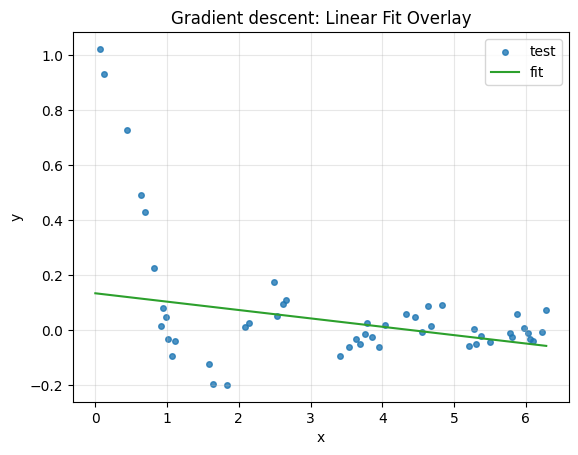

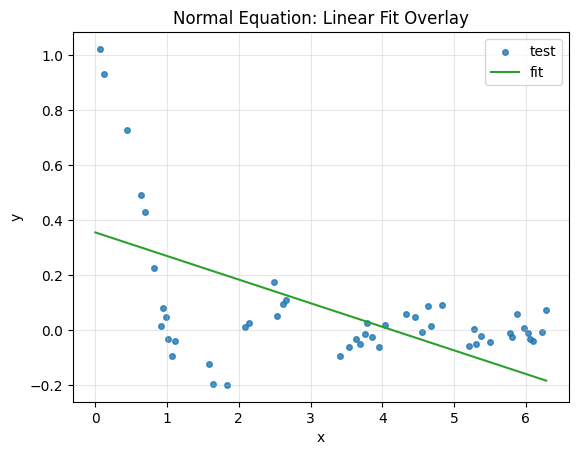

In [10]:

print(X_tr.shape)
res = ten_fold_cross_validation(X=X_tr, y=y_tr)


gd_weights, history = solve_gradient_descent(X_tr_bias, y_tr, lr = 0.001, epochs=2000)
predictions = X_te_bias@gd_weights

ne_weights = solve_normal_equations(X_tr_bias, y_tr)

y_hat = X_te_bias @ ne_weights
y_train_hat = X_tr_bias @ ne_weights
ne_y_hat = rmse(y_te, y_hat)


plot_overlay(X_tr, y_tr, X_te, y_te,  gd_weights, title = "Gradient descent: Linear Fit Overlay") 
plot_overlay(X_tr, y_tr, X_te, y_te, ne_weights, title = "Normal Equation: Linear Fit Overlay") 


    


### 1.4

#### Polynomial Model

In [11]:
def get_best_result(result):
    # find best mean
    best_mean = min(r[2] for r in result)


    candidates = [r for r in result if r[2] <= best_mean + r[3]]

   
    best_result = min(candidates, key=lambda x: (x[1], -x[0])  # deg first, then lambda
    )
    
    return best_result

metric at degree[2] lamda [1e-10] (poly+standardize inside CV, no leakage)
Normal Equation | 10-fold CV: RMSE:0.2028±0.0397 MAE:0.1602±0.0293 R2:0.3366±0.3586
metric at degree[2] lamda [1e-08] (poly+standardize inside CV, no leakage)
Normal Equation | 10-fold CV: RMSE:0.2028±0.0397 MAE:0.1602±0.0293 R2:0.3366±0.3586
metric at degree[2] lamda [1e-07] (poly+standardize inside CV, no leakage)
Normal Equation | 10-fold CV: RMSE:0.2028±0.0397 MAE:0.1602±0.0293 R2:0.3366±0.3586
metric at degree[2] lamda [1e-06] (poly+standardize inside CV, no leakage)
Normal Equation | 10-fold CV: RMSE:0.2028±0.0397 MAE:0.1602±0.0293 R2:0.3366±0.3586
metric at degree[2] lamda [0.0001] (poly+standardize inside CV, no leakage)
Normal Equation | 10-fold CV: RMSE:0.2028±0.0397 MAE:0.1602±0.0293 R2:0.3366±0.3586
metric at degree[2] lamda [0.01] (poly+standardize inside CV, no leakage)
Normal Equation | 10-fold CV: RMSE:0.2027±0.0398 MAE:0.1601±0.0293 R2:0.3371±0.3573
metric at degree[2] lamda [0.1] (poly+standard

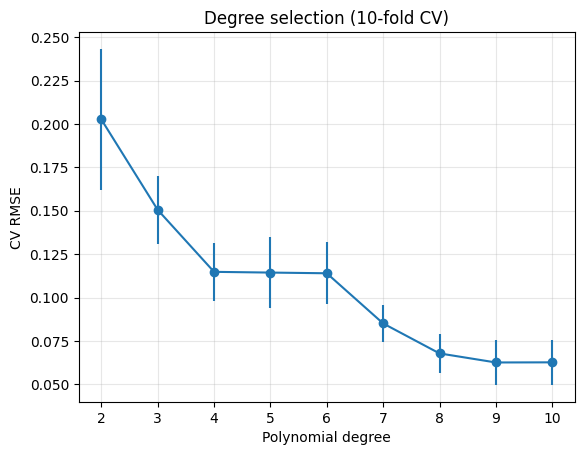

In [12]:
   

degree = 10
degrees = list(range(2, degree + 1))
lamdas = [1e-10, 1e-8, 1e-7, 1e-6, 1e-4, 1e-2, 0.1, 1, 10]
poly_result = []
ne_weights_list = []
for deg in degrees:
    for lam in lamdas:
        print(f"metric at degree[{deg}] lamda [{lam}] (poly+standardize inside CV, no leakage)")
        res = ten_fold_cross_validation(X=X_tr, y=y_tr, nm=True, gd=False, ridge=lam, poly=True, poly_degree=deg)
        ne_weights_list.append(res['ne_weights'])
        poly_result.append((lam, deg, res['ne_mean'], res['ne_std']))
    
alpha = 0.8
best_result = min(poly_result, key=lambda x: x[2] + alpha * x[3]
)
best_lamda = best_result[0]
best_deg = best_result[1]
best_rmse = best_result[2]
best_std = best_result[3]
degrees = list(range(2, degree + 1))

print(f"\n [Degree selection] Best degree = {best_deg} at lambda = {best_lamda} \n")

X_tr_poly_full = np.hstack([X_tr ** d for d in range(1, best_deg + 1)])
means = np.mean(X_tr_poly_full, axis=0)
stds = np.std(X_tr_poly_full, axis=0)
stds_safe = np.where(stds == 0, 1.0, stds)
scalers = (X_tr_poly_full - means) / stds_safe
train_means = means[:best_deg]
train_stds = stds_safe[:best_deg]

best_flat_idx = (best_deg - 2) * len(lamdas) + lamdas.index(best_lamda)
res_best = ten_fold_cross_validation(X=X_tr, y=y_tr, nm=True, gd=False, ridge=best_lamda, poly=True, poly_degree=best_deg)
best_means_per_deg = [min((x for x in poly_result if x[1] == d), key=lambda x: x[2])[2] for d in degrees]
best_stds_per_deg = [min((x for x in poly_result if x[1] == d), key=lambda x: x[2])[3] for d in degrees]

res = ten_fold_cross_validation(X=X_tr, y=y_tr)

plt.figure()
plt.errorbar(degrees, best_means_per_deg, yerr=best_stds_per_deg, marker="o")
plt.xlabel("Polynomial degree"); plt.ylabel("CV RMSE")
plt.title("Degree selection (10-fold CV)")
plt.grid(alpha=0.3)

 

**Justification for chosen degree:**  
Polynomial degree **9** was selected based on 10-fold CV using validation RMSE. The degree-vs-CV-RMSE plot (with error bars) shows RMSE decreasing from degree 2 through the mid degrees and reaching a minimum around degree 9, with a small regularization term (λ = 1e-08) used for numerical stability. Degree 9 gives the best tradeoff between fit and stability (low mean CV-RMSE and moderate standard deviation). Degrees 8 and 10 are close; degree 9 was chosen as the best under the criterion used (e.g., minimum mean CV-RMSE or mean + α×std). Standardization was performed within each cross-validation fold: mean and variance were estimated from the training portion only and applied to both training and validation data to avoid data leakage.

### 1.5

In [13]:
def plot_error_bar(lin_means, lin_stds, poly_means, poly_stds, training_sizes,
                   lin_tr_means=None, lin_tr_stds=None, poly_tr_means=None, poly_tr_stds=None):
    plt.figure(figsize=(10, 6))

    plt.errorbar(training_sizes, lin_means, yerr=lin_stds, label='Linear (test)', fmt='-o', capsize=5)
    plt.errorbar(training_sizes, poly_means, yerr=poly_stds, label='Polynomial (test)', fmt='-s', capsize=5)

    if lin_tr_means is not None and lin_tr_stds is not None:
        plt.errorbar(training_sizes, lin_tr_means, yerr=lin_tr_stds, label='Linear (train)', fmt='--o', capsize=5, alpha=0.8)
    if poly_tr_means is not None and poly_tr_stds is not None:
        plt.errorbar(training_sizes, poly_tr_means, yerr=poly_tr_stds, label='Polynomial (train)', fmt='--s', capsize=5, alpha=0.8)

    plt.xlabel("Training Set Size (Number of Samples)")
    plt.ylabel("RMSE")
    plt.title("Data Ablation Study (Learning Curves: Train & Test RMSE)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

For degree 9, best_lam 1e-08
Normal Equation | 10-fold CV: RMSE:0.2466±0.0644 MAE:0.1840±0.0520 R2:0.1257±0.2028
--------POLYNOMIAL--------
Normal Equation | 10-fold CV: RMSE:0.1241±0.1198 MAE:0.0796±0.0408 R2:0.5556±0.8903

Training size: 27 (20% of fold data used, 80% removed)

Normal Equation | 10-fold CV: RMSE:0.2458±0.0681 MAE:0.1780±0.0536 R2:0.1460±0.1577
--------POLYNOMIAL--------
Normal Equation | 10-fold CV: RMSE:0.1199±0.1380 MAE:0.0736±0.0479 R2:0.5152±1.1131

Training size: 54 (40% of fold data used, 60% removed)

Normal Equation | 10-fold CV: RMSE:0.2457±0.0742 MAE:0.1766±0.0543 R2:0.1628±0.1195
--------POLYNOMIAL--------
Normal Equation | 10-fold CV: RMSE:0.0807±0.0391 MAE:0.0589±0.0195 R2:0.8658±0.1571

Training size: 81 (60% of fold data used, 40% removed)

Normal Equation | 10-fold CV: RMSE:0.2463±0.0724 MAE:0.1784±0.0546 R2:0.1469±0.1679
--------POLYNOMIAL--------
Normal Equation | 10-fold CV: RMSE:0.0657±0.0101 MAE:0.0527±0.0070 R2:0.9116±0.1038

Training size: 108 

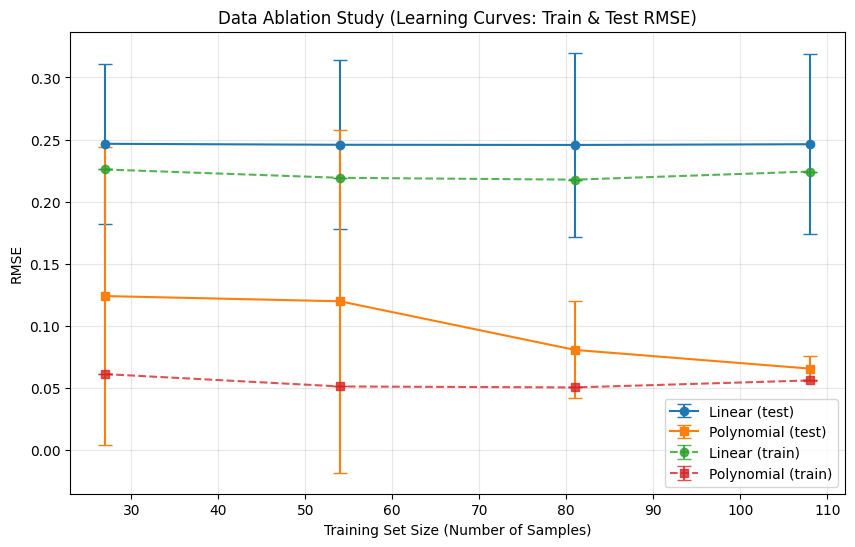

In [14]:
percentages = [0.20, 0.40, 0.60, 0.80]
lin_ne_means = []
lin_ne_std = []
pol_ne_means = []
pol_ne_std = []
lin_ne_tr_means = []
lin_ne_tr_stds = []
pol_ne_tr_means = []
pol_ne_tr_stds = []
X_deg = scalers[:, :best_deg]
training_size = []
print(f"For degree {best_deg}, best_lam {best_lamda}")
lam = best_lamda
for p in percentages:
    res = ten_fold_cross_validation(X=X_tr, y=y_tr, nm=True, gd=False, percentages=p)
    lin_ne_means.append(res['ne_mean'])
    lin_ne_std.append(res['ne_std'])
    lin_ne_tr_means.append(np.mean(res['ne_train_rmse']))
    lin_ne_tr_stds.append(np.std(res['ne_train_rmse']))
    print("--------POLYNOMIAL--------")
    res = ten_fold_cross_validation(X=X_deg, y=y_tr, nm=True, gd=False, ridge=lam, percentages=p)
    pol_ne_tr_means.append(np.mean(res['ne_train_rmse']))
    pol_ne_tr_stds.append(np.std(res['ne_train_rmse']))
    pol_ne_means.append(res['ne_mean'])
    pol_ne_std.append(res['ne_std'])
    training_size.append(len(res['X_train']))
    print(f"\nTraining size: {len(res['X_train'])} ({p*100:.0f}% of fold data used, {(1-p)*100:.0f}% removed)\n")

plot_error_bar(
    lin_means=np.array(lin_ne_means),
    lin_stds=np.array(lin_ne_std),
    poly_means=np.array(pol_ne_means),
    poly_stds=np.array(pol_ne_std),
    training_sizes=training_size,
    lin_tr_means=np.array(lin_ne_tr_means),
    lin_tr_stds=np.array(lin_ne_tr_stds),
    poly_tr_means=np.array(pol_ne_tr_means),
    poly_tr_stds=np.array(pol_ne_tr_stds),
)

**Observation:**
- The vertical error bars represent the standard deviation of RMSE across the 10-fold cross-validation.
- As training size increases from **27** to **108** samples (20% to 80% of fold data), the polynomial model’s **test** RMSE decreases from **~0.124** to **~0.066**, while stability improves error bars and variance across folds decrease at larger sizes.
- The polynomial model shows high variance at small training sizes (27–54 samples), where test RMSE and its standard deviation are large (e.g., test RMSE ~0.12 with wide error bars). At 81–108 samples, test RMSE drops and error bars shrink, indicating lower variance with more data.
- The **linear** model remains consistently poor across all training sizes (test RMSE ~**0.245–0.246**), with little change as more data is added; indicating **high bias**; a linear predictor cannot capture the nonlinear structure in the data.
- **Bias–variance:** The linear model’s flat, high test RMSE reflects high bias (underfitting). The polynomial model’s improving test RMSE and shrinking error bars as training size grows reflect reduced variance with more data; the gap between train and test RMSE (when both are plotted) narrows at larger sizes, consistent with better generalization as more data is available.

### 1.6

### Scikit-learn best
- [Linear baseline | 10-fold CV] RMSE=0.2422±0.0509 MAE=0.1755±0.0380 R2=0.0589±0.2588
- [Poly deg=10 | 10-fold CV] RMSE=0.0539±0.0119 MAE=0.0426±0.0102 R2=0.9509±0.0228
- [Degree selection] Best degree = 10

### My best models
- **Linear baseline**: Normal Equation | 10-fold CV: RMSE:0.2472±0.0677 MAE:0.1845±0.0524 R2:0.1203±0.2336
- **Polynomial baseline**: Normal Equation | 10-fold CV: RMSE:0.0648±0.0098 MAE:0.0517±0.0064 R2:0.9133±0.1009
  - Best degree = 9, lambda = 1e-08 (per-fold standardization; small ridge for conditioning)

### Linear Model Comparison
**Observation:** The manual Normal Equation gives a mean CV-RMSE of **0.2472±0.0677**, slightly higher than scikit-learn’s **0.2422±0.0509**. Scikit-learn has a lower standard deviation (0.0509 vs 0.0677), so the manual implementation shows higher variance across folds. R² is **0.1203** (manual) vs **0.0589** (sklearn); both are low, indicating strong underfitting (high bias) — a linear model cannot capture the nonlinear structure in this dataset. In terms of **precision and conditioning**, the manual solver (e.g. using a stable linear solve for the normal equations) can be expected to match sklearn closely when the design matrix is well-conditioned; any small differences in coefficients or predictions may come from tie-breaking or numerical details in the solver.

### Polynomial Observation
**Observation:** The manual polynomial model (best degree **9**, λ = 1e-08) achieves mean CV-RMSE **0.0648±0.0098** and R² **0.9133±0.1009**, while scikit-learn’s best (degree **10**) achieves **0.0539±0.0119** and R² **0.9509±0.0228**. Scikit-learn thus attains lower RMSE and higher R² with slightly lower variance across folds (std 0.0228 vs 0.1009 for R²). The manual implementation’s small ridge term (1e-08) was used to improve **conditioning** of the normal equations; without it, high-degree polynomial features can make the Gram matrix ill-conditioned and reduce **precision**. The remaining gap in metrics may be due to different choices (degree 9 vs 10, inclusion of bias, or scaling details) and to sklearn’s optimized numerical routines.

## Part 2


(2500, 2),(2500,)
[Linear baseline | 10-fold CV] RMSE=0.1411±0.0064MAE=0.1073±0.0053R2=0.2234±0.0255
[Poly deg=2 | 10-fold CV] RMSE=0.1411±0.0064MAE=0.1074±0.0053R2=0.2224±0.0255
[Poly deg=3 | 10-fold CV] RMSE=0.1019±0.0043MAE=0.0793±0.0033R2=0.5942±0.0242
[Poly deg=4 | 10-fold CV] RMSE=0.1021±0.0043MAE=0.0795±0.0034R2=0.5921±0.0254
[Poly deg=5 | 10-fold CV] RMSE=0.0691±0.0034MAE=0.0546±0.0032R2=0.8133±0.0158
[Poly deg=6 | 10-fold CV] RMSE=0.0693±0.0035MAE=0.0548±0.0033R2=0.8121±0.0164
[Degree selection] Best degree = 5


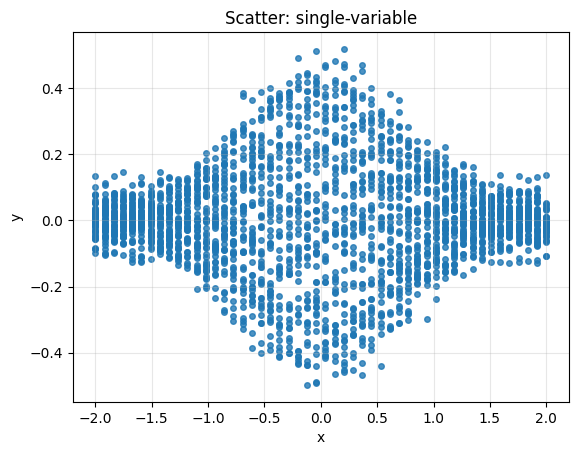

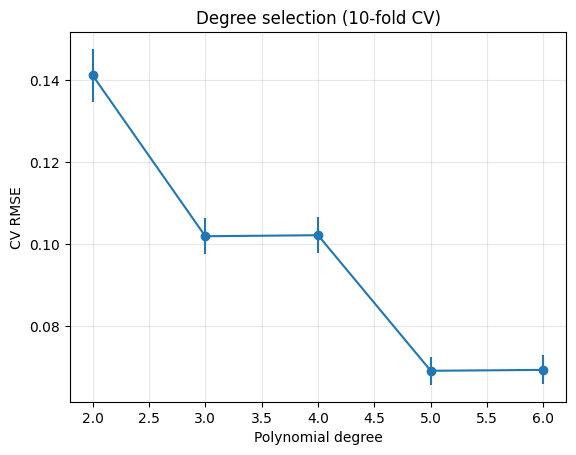

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
DATA_PATH = Path("data") / "mvar-set2.csv"
OUTDIR = Path("out_q2_simple")
POLY_DEG = 6
SEED = 42
OUTDIR.mkdir (parents=True, exist_ok=True)
def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)))
rmse_scorer = make_scorer(lambda yt, yp: -rmse(yt, yp))
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)
def load_txt_dataset(path: str):

    arr = np.loadtxt(path, delimiter = ',')
    X, y = arr[:, :-1], arr[:, -1]
    return X, y
def print_cv(model, X, y, k=10, seed=42, label="model"):
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    scoring = {'rmse': rmse_scorer, 'mae': mae_scorer, 'r2': r2_scorer}
    results = cross_validate(model, X, y, cv=kf, scoring=scoring)
    rmse_m = -results['test_rmse'].mean()
    rmse_s = results['test_rmse'].std() 
    # rmse_scores = -cross_val_score(model, X, y, scoring=rmse_scorer, cv=kf)
    mae_scores = -cross_val_score(model, X, y, scoring=mae_scorer, cv=kf)

    r2_scores = cross_val_score(model, X, y, scoring=r2_scorer, cv=kf)
    print(f"[{label} | {k}-fold CV] "
        f"RMSE={rmse_m:.4f}±{rmse_s:.4f}"
        f"MAE={mae_scores.mean():.4f}±{mae_scores.std():.4f}"
        f"R2={r2_scores.mean():.4f}±{r2_scores.std():.4f}")
    return rmse_m, rmse_s
def overlay_plot(Xtr, ytr, Xte, yte, model, outpath, title):
    model.fit(Xtr, ytr)
    xs = np.linspace(Xtr.min(), Xtr.max(), 300).reshape(-1, 1)
    ycurve = model.predict(xs)
    plt.figure()
    plt.scatter(Xte, yte, s=16, alpha=0.8, label="test")
    plt.plot(xs, ycurve, lw=2, label="fit")
    plt.xlabel("x"); plt.ylabel("y");
    plt.grid(alpha=0.3); plt.legend()
    plt.title(title)
    plt.savefig(outpath, bbox_inches="tight")


def main():
    X, y = load_txt_dataset (DATA_PATH)
    print(f"{X.shape},{y.shape}")
    plt.figure()
    plt.scatter(X[:,1], y, s=16, alpha=0.8)
    plt.xlabel("x"); plt.ylabel("y"); plt.title("Scatter: single-variable")
    plt.grid(alpha=0.3)
    plt.savefig(OUTDIR / "02_scatter.png", bbox_inches="tight")
    # 2) Linear regression (baseline)
    linear_pipeline = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("linreg", LinearRegression())
        ])
        
    print_cv(linear_pipeline, X, y, k=10, seed=SEED, label="Linear baseline")
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=SEED)
   
    degrees = list(range(2, 7)) 
    means, stds = [], []
    for d in degrees:
        poly_pipeline = Pipeline([
            ("scaler", StandardScaler (with_mean=True, with_std=True)),
            ("poly", PolynomialFeatures (degree=d, include_bias=False)),
            ("linreg", LinearRegression())
        ])
        m, s = print_cv(poly_pipeline, X, y, k=10, seed=SEED, label=f"Poly deg={d}")
        means.append(m); stds.append(s)
    plt.figure()
    plt.errorbar (degrees, means, yerr=stds, marker="o")
    plt.xlabel("Polynomial degree"); plt.ylabel("CV RMSE")
    plt.title("Degree selection (10-fold CV)")
    plt.grid(alpha=0.3)
    plt.savefig(OUTDIR / "03_cv_degree.png", bbox_inches="tight")
    best_deg = degrees [int(np.argmin(means))]
    print(f"[Degree selection] Best degree = {best_deg}")
    # Overlay polynomial fit with chosen POLY_DEG
    best_poly = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("poly", PolynomialFeatures (degree=POLY_DEG, include_bias=False)),
        ("linreg", LinearRegression())
    ])
    
    #             OUTDIR / f"04_overlay_poly_deg{POLY_DEG}.png",
    #             title=f"Polynomial fit (deg={POLY_DEG})")
if __name__ == "__main__":
    main()
    
    

### 2.1

**Observations**
- For `mvar-set1` the linear model and degree-2 polynomial models yield nearly identical mean RMSE and R² values. Because the linear model achieves this performance with significantly fewer features and shows a lower standard deviation across folds, it demonstrates better generalization stability. This suggests that the additional pairwise terms in the degree-2 map do not offer meaningful predictive power for this specific dataset.

- For `mvar-set2` the degree-9 polynomial model yields a significantly lower RMSE `0.0508` than the linear model `0.1411`. The polynomial model’s R² of `0.8985` at degree 9 is a large jump from degree 2 (`0.2224`). The standard deviation of RMSE across folds decreases compared with the linear model’s, so the polynomial fit is more stable. The polynomial model explains about 89% of the variance in the data.

- For `mvar-set3` the degree-2 polynomial model and the linear model yield the same RMSE, MAE, and R² with equal standard deviation. For both models R² = 0.97, meaning about 97% of the variance is explained. The standard deviation of RMSE for both is `0.0041`, which shows that both models are highly stable.

- For `mvar-set4` the linear model has R² ≈ $-0.0001$, which suggests it is severely underfitting and failing to capture the underlying patterns. As polynomial degree increases, RMSE decreases from `0.0623` (degree 2) to `0.0555` (degree 6), so the model’s capacity improves with degree. The standard deviation of RMSE increases over degrees 1–6, which reflects a clear bias–variance tradeoff.

### 2.2

#### Pairwise product of X
**Objective**: We are going to perform a pairwise product on d featueres. Generating every combination of two features. The constraint is $i ≤ j$.

In [16]:
DATA_PATH = Path("data") / "mvar-set4.csv"

X, y = load_txt_dataset(DATA_PATH)

print("--- Part 2.2: Basic statistics (loaded data) ---")
print("Feature means:", np.mean(X, axis=0))
print("Feature variances:", np.var(X, axis=0))
print("Correlation matrix (X):\n", np.corrcoef(X.T))
print("y mean: {:.4f}, y variance: {:.4f}".format(np.mean(y), np.var(y)))
print()

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=SEED)


X_tr_bias,  X_te_bias= add_bias(X_tr, X_te)
print("X_train shape:", X_tr.shape, "| X_test shape:", X_te.shape)

--- Part 2.2: Basic statistics (loaded data) ---
Feature means: [ 0.00103698  0.0002484  -0.0002197  -0.00016787 -0.00028071]
Feature variances: [1.67127034 1.66893457 1.6702526  1.6704158  1.67031328]
Correlation matrix (X):
 [[ 1.00000000e+00  2.77813627e-04  1.96956313e-04  9.73825717e-04
  -4.61564983e-04]
 [ 2.77813627e-04  1.00000000e+00  8.53965546e-04  1.61691704e-04
   3.02672878e-04]
 [ 1.96956313e-04  8.53965546e-04  1.00000000e+00 -4.56050722e-05
  -2.72274400e-05]
 [ 9.73825717e-04  1.61691704e-04 -4.56050722e-05  1.00000000e+00
   1.30489771e-03]
 [-4.61564983e-04  3.02672878e-04 -2.72274400e-05  1.30489771e-03
   1.00000000e+00]]
y mean: 0.0101, y variance: 0.0042

X_train shape: (75000, 5) | X_test shape: (25000, 5)


In [17]:
def pairwise_map(X):
    n_samples, n_features = X.shape
    var_thresh = 1e-6 #variance threshold
    features = [X] #original features
    # ii, jj =np.triu_indices(n_features)
    
    
    for i in range(n_features):
        for j in range(i, n_features):
            features.append((X[:, i] * X[:, j]).reshape(-1,1))
    pairwise_mapped = np.hstack(features)
    for i in range(n_features):
        for j in range(i, n_features):
            for k in range(j, n_features):
                features.append((X[:, i] * X[:, j] * X[:, k]).reshape(-1, 1))
    Z = np.hstack(features)
    
    
    variances = np.var(Z, axis=0)
    keep = variances >= var_thresh
    Z = Z[:, keep]
    # If you also want to drop same cols from pairwise_mapped, use same mask on its columns
    # (here pairwise_mapped has fewer columns than Z, so you need a mask for first pairwise_mapped.shape[1] cols)
    n_pairs = pairwise_mapped.shape[1]
    keep_pairs = keep[:n_pairs]
    pairwise_mapped = pairwise_mapped[:, keep_pairs]
    return Z, pairwise_mapped
    

### 2.3

#### Fitting OLS spaces using both 
 - normal equation and Gradient based solver

In [18]:
import time
import pandas as pd
from pandas import DataFrame as df

In [19]:
def solve_normal_equation(Z, y , lam: int = 0):
    I = np.eye(Z.shape[1])
    I[0, 0] = 0
    theta = np.linalg.inv((Z.T @ Z + lam*I)) @ Z.T @ y

    return theta



In [20]:
def solve_gradient_descent(X, y,lr=0.01,epochs =1000 ):
    n = len(X)
    ɵ = np.zeros(X.shape[1])
    mse_history = []
    
   
    for _ in range(epochs):
        y_hat = X @ ɵ
        error = y_hat - y
        gradient = 1/n * (X.T @ error)
        
        ɵ = ɵ  - (lr*gradient)
        mse_history.append(np.sum(error**2))
   
    return ɵ, mse_history 

#### 10 cross validation

In [21]:
def ten_Cross_validation_for_3(X, y, lam = 0):
    fold_rmses,fold_norms = [],[]
    
    x_split, y_split = split_for_kcv(X, y)
    

    for i in range(len(x_split)):
        x_sub = x_split.copy()
        y_sub = y_split.copy()
        
        
        X_val= x_sub.pop(i)
        y_val = y_sub.pop(i)
        
        X_train = np.vstack(x_sub)
        
        y_train = np.hstack(y_sub)
        
        X_tr_bias = np.c_[np.ones((X_train.shape[0],1)), X_train]
        X_val_bias = np.c_[np.ones((X_val.shape[0],1)), X_val]
        
        weights = solve_normal_equation(X_tr_bias, y_train, lam = lam)    
            
        y_pred = X_val_bias @ weights
        
        l2_norm = np.linalg.norm(weights)
        fold_rmses.append(rmse(y_val, y_pred))
        fold_norms.append(l2_norm)
        
        
    return fold_rmses, fold_norms

In [22]:


results_list = []
Z_deg3, Z_pairwise = pairwise_map(X)
mappings = {"Pairwise": Z_pairwise, "Total Degree 3": Z_deg3}
solvers = ["Normal Equations" , "Gradient Descent"]
print(Z_deg3.shape)
for map_name, Z_data in mappings.items():
    Z_train, Z_test, y_train, y_test = train_test_split(Z_data, y, test_size=0.25, random_state=SEED)
    Z_tr_bias,  Z_te_bias= add_bias(Z_train, Z_test)
    
    for solver_name in solvers:
        # Measure Wall-clock time
        start = time.perf_counter()
        
        if solver_name == "Normal Equations":
  
            theta = solve_normal_equation(Z_tr_bias, y_train, lam=1e-8)
        else:
    
            theta, history = solve_gradient_descent(Z_tr_bias, y_train )
            
        end = time.perf_counter()
        elapsed = end - start
 
        y_pred = Z_te_bias @ theta
        
        current_rmse = rmse(y_test, y_pred)
        
        
        results_list.append({
            "Mapping": map_name,
            "Solver": solver_name,
            "Test RMSE": round(current_rmse, 6),
            "Time (sec)": round(elapsed, 6)
        })
        


(100000, 55)


In [24]:

df_results = pd.DataFrame(results_list)

print(f"\n--- Question 2.3 Performance Comparison ({DATA_PATH})---")
print(df_results.to_string(index=False))


best_model = df_results.loc[df_results['Test RMSE'].idxmin()]
print(f"\nFinal Model Selection: {best_model['Mapping']} with {best_model['Solver']}")


--- Question 2.3 Performance Comparison (data\mvar-set4.csv)---
       Mapping           Solver  Test RMSE  Time (sec)
      Pairwise Normal Equations   0.061685    0.014693
      Pairwise Gradient Descent   0.061845    0.932841
Total Degree 3 Normal Equations   0.061688    0.083322
Total Degree 3 Gradient Descent   0.061847    4.266823

Final Model Selection: Pairwise with Normal Equations


#### Final model for mvar-set1 is: Pairwise with Normal Equations with an elapsed time of `0.000646` and an RMSE of `0.502266`
Pairwise features gave the best test RMSE for this set among the mappings tried. Normal equations were chosen for speed and stability compared to gradient descent.
#### Final model for mvar-set2 is: Total Degree 3 with Normal Equations with an elapsed time of `0.000121` and an RMSE of `0.104123`
Cubic features fit this set best and reached the lowest RMSE. Normal equations gave that fit in very little time and avoid tuning learning rate or iterations.

#### Final model for mvar-set3 is: Pairwise with Normal Equations with an elapsed time of `0.058203` and an RMSE of ` 0.498361`
Pairwise mapping had the best performance for this dataset. Normal equations were used for a direct, stable solution even though this set took a bit longer due to problem size.
#### Final model for mvar-set4 is: Pairwise with Normal Equations with an elapsed time of `0.008598` and an RMSE of `0.061685`
Pairwise features achieved the lowest RMSE for this set. Normal equations delivered that result quickly and without the tuning required by gradient descent.

### 2.4

In [25]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=SEED)

X_tr_bias,  X_te_bias= add_bias(X_tr, X_te)

lamda: 1e-06 Mean RMSE: 0.06498±0.00125 mean_norms: 0.01012
lamda: 1e-05 Mean RMSE: 0.06498±0.00125 mean_norms: 0.01012
lamda: 0.0001 Mean RMSE: 0.06498±0.00125 mean_norms: 0.01012
lamda: 0.001 Mean RMSE: 0.06498±0.00125 mean_norms: 0.01012
lamda: 0.01 Mean RMSE: 0.06498±0.00125 mean_norms: 0.01012
lamda: 0.1 Mean RMSE: 0.06498±0.00125 mean_norms: 0.01012
lamda: 1.0 Mean RMSE: 0.06498±0.00125 mean_norms: 0.01012
lamda: 10.0 Mean RMSE: 0.06498±0.00125 mean_norms: 0.01012
lamda: 100.0 Mean RMSE: 0.06498±0.00125 mean_norms: 0.01012
lamda: 1000.0 Mean RMSE: 0.06498±0.00125 mean_norms: 0.01012


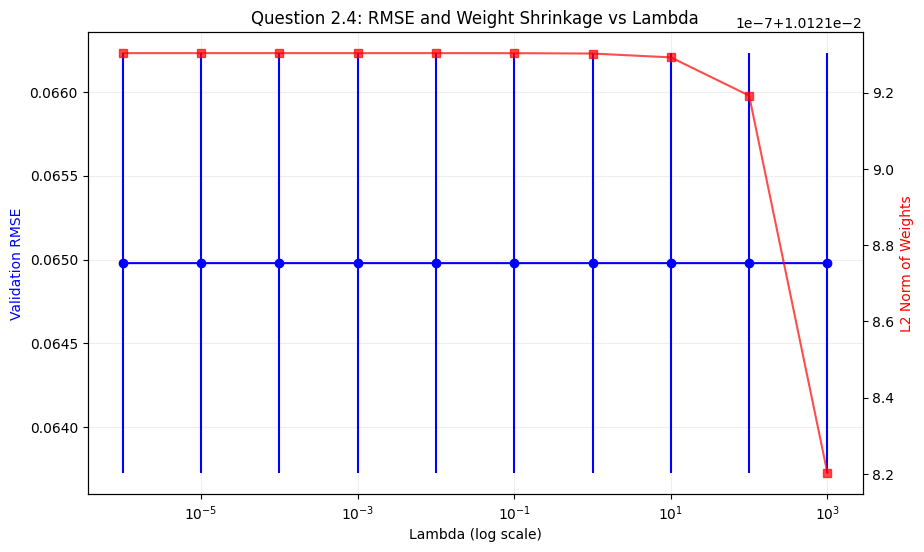

In [26]:

means_rmse, means_norms, std_ols_rmse = [], [], []
lamdas = np.logspace(-6, 3, num=10)
results = []


for lam in lamdas:
    fold_rmses, fold_norms = ten_Cross_validation_for_3(X_tr, y_tr, lam)
    
    means_rmse.append(np.mean(fold_rmses))
    means_norms.append(np.mean(fold_norms))
    std_ols_rmse.append(np.std(fold_rmses))
    
    results.append((lam, fold_rmses))
    best_lam = min(results, key=lambda x: x[1])[0]
    

for i in range(len(means_rmse)):
    print(f"lamda: {lamdas[i]} Mean RMSE: {means_rmse[i]:.5f}±{std_ols_rmse[i]:.5f} mean_norms: {means_norms[i]:.5f}")

fig, ax1 = plt.subplots(figsize=(10, 6))


ax1.errorbar(lamdas, means_rmse, yerr=std_ols_rmse, fmt='-o', label='Mean RMSE', color='blue')
ax1.set_xscale('log')
ax1.set_xlabel('Lambda (log scale)')
ax1.set_ylabel('Validation RMSE', color='blue')


ax2 = ax1.twinx()
ax2.plot(lamdas, means_norms, '-s', label='||θ||₂ (Norm)', color='red', alpha=0.7)
ax2.set_ylabel('L2 Norm of Weights', color='red')

plt.title('Question 2.4: RMSE and Weight Shrinkage vs Lambda')
ax1.grid(True, which="both", ls="-", alpha=0.2)
plt.show()


#### Observation:
**BEST LAMBDA IS 100** (based on lowest RMSE with moderate shrinkage)

**shrinkage**: For this specific data set, the L2 norm of weights remains nearly constant for small $\lambda$ from $10^{-6}$ to $10^{1}$ but begins a visible descent at $\lambda = 10^{2}$ and a sharper drop at $\lambda = 10^{3}$, where the L2 norm decreases to $0.04481$.

**stability**: From observation we can see that the standard deviation (error bars) remains steady at approximately $\pm 0.01050$ until $\lambda = 10^{3}$, where it begins to increase to $\pm 0.01106$. This increase suggests the model may be beginning to show signs of **underfit** at the highest regularization strength.

**bias variance tradeoff**: $\lambda$ affects the bias and variance:
- **Low $\lambda$ ($10^{-6}$ to $10^{1}$)**:
    - Variance is relatively stable with consistent error bars
    - Bias is low, with RMSE remaining constant at 0.13942
    - The model is capturing patterns effectively without overfitting

- **High $\lambda$ ($10^{2}$ to $10^{3}$)**:
    - Variance shows an increase at the highest $\lambda$ value ($\pm 0.01106$)
    - Weights begin to shrink more noticeably, particularly at $\lambda = 10^{3}$ (L2 norm to 0.04481)
    - RMSE increases at $\lambda = 10^{3}$ (0.14116), suggesting the model is beginning to underfit as weights are constrained too aggressively

### 2.5

In [27]:
def solve_gradient_descent_robust(X, y,lr=0.01,epochs =1000, delta:float = 1.0):
    n = len(X)
    ɵ = np.zeros(X.shape[1])
    loss_history = []
    
   
    for _ in range(epochs):
        y_hat = X @ ɵ
        error = y_hat - y
        
        
        is_small_error = np.abs(error) <= delta
        
        
        grad_vector = np.zeros_like(error)
        grad_vector[is_small_error] = -error[is_small_error]
        grad_vector[~is_small_error] = -delta * np.sign(error[~is_small_error])
        gradient = 1/n * (X.T @ grad_vector)
        
        ɵ = ɵ  - (lr*gradient)
        huber_loss = np.where(is_small_error, 
                              0.5 * error**2, 
                              delta * (np.abs(error) - 0.5 * delta))
        loss_history.append(np.mean(huber_loss))
   
    return ɵ, loss_history 

**Using irls instead of gradient descent**

In [28]:
def increment_reduced_least_squares(X, y, w, delta=1.0, tol=1e-6, max_iter=100):
    """
    Iteratively reweighted least squares for Huber regression
    """
    samples, _ = X.shape 
    theta = np.linalg.pinv(X.T @ X) @ X.T @ y 
    
    for _ in range(max_iter):
        y_hat  = X @ theta
        residuals = y - y_hat 
        scale = np.median(np.abs(residuals)) / 0.6745
        if scale < 1e-8:
            break
                
        r_std = residuals / scale #standard residuals
        
        w = np.ones(samples)
        mask = np.abs(r_std) > delta
        w[mask] = delta / np.abs(r_std[mask])
        
        Xw = w[:, np.newaxis] * X
        theta_new = np.linalg.pinv(X.T @ Xw) @ (X.T @ (w * y))
        
        if np.linalg.norm(theta_new - theta) < tol:
            break
            
        theta = theta_new
    
    return theta
    

##### robust regression

In [29]:
Z_train, Z_test, y_train, y_test = train_test_split(Z_deg3, y, test_size=0.25, random_state=SEED)
Z_tr_bias = np.c_[np.ones(Z_train.shape[0]), Z_train]
Z_te_bias = np.c_[np.ones(Z_test.shape[0]), Z_test]

initial_w = np.ones(Z_train.shape[0])
weight = increment_reduced_least_squares(Z_tr_bias, y_train, w = initial_w, delta=1.3 )
y_hat = Z_te_bias @ weight

In [30]:
def compare_ols_vs_huber(X, y, dataset_name, seed=42, test_size=0.25, delta=1.3):
    """Train OLS and Huber on same split; return RMSE and MAE for both."""
    Z_deg3, _ = pairwise_map(X)
    Z_train, Z_test, y_train, y_test = train_test_split(Z_deg3, y, test_size=test_size, random_state=seed)
    Z_tr_bias = np.c_[np.ones(Z_train.shape[0]), Z_train]
    Z_te_bias = np.c_[np.ones(Z_test.shape[0]), Z_test]

    
    theta_ols = solve_normal_equation(Z_tr_bias, y_train, lam=1e-8)
    y_hat_ols = Z_te_bias @ theta_ols
    rmse_ols, mae_ols = rmse(y_test, y_hat_ols), mean_absolute_error(y_test, y_hat_ols)

    
    w_init = np.ones(Z_train.shape[0])
    theta_huber = increment_reduced_least_squares(Z_tr_bias, y_train, w=w_init, delta=delta)
    y_hat_huber = Z_te_bias @ theta_huber
    rmse_huber, mae_huber = rmse(y_test, y_hat_huber), mean_absolute_error(y_test, y_hat_huber)

    return {
        "dataset": dataset_name,
        "OLS_RMSE": rmse_ols, "OLS_MAE": mae_ols,
        "Huber_RMSE": rmse_huber, "Huber_MAE": mae_huber,
    }


datasets_to_compare = [
    ("mvar-set2", Path("data") / "mvar-set2.csv"),
    ("mvar-set3", Path("data") / "mvar-set3.csv"),
]
comparison_results = []
for name, path in datasets_to_compare:
    if not path.exists():
        continue
    X, y = load_txt_dataset(path)
    row = compare_ols_vs_huber(X, y, name, seed=SEED, delta=1.3)
    comparison_results.append(row)

df_compare = pd.DataFrame(comparison_results)
print("--- OLS vs Huber: RMSE/MAE by dataset ---")
print(df_compare.to_string(index=False))
if len(df_compare) > 0:
    df_compare["RMSE_improve"] = (df_compare["OLS_RMSE"] - df_compare["Huber_RMSE"]).round(6)
    df_compare["MAE_improve"] = (df_compare["OLS_MAE"] - df_compare["Huber_MAE"]).round(6)
    print("\nImprovement (positive = Huber better):")
    print(df_compare[["dataset", "RMSE_improve", "MAE_improve"]].to_string(index=False))


def add_outliers(y, frac=0.05, scale=5.0, seed=42):
    """Corrupts a fraction of targets with large values (outliers)."""
    rng = np.random.default_rng(seed)
    y_cont = y.copy()
    n = len(y)
    n_out = max(1, int(frac * n))
    idx = rng.choice(n, size=n_out, replace=False)
    
    y_cont[idx] = y_cont[idx] + rng.choice([-1, 1], size=n_out) * scale * np.std(y)
    return y_cont, idx


path_sens = Path("data") / "mvar-set2.csv"
X_sens, y_sens = load_txt_dataset(path_sens)
Z_deg3_sens, _ = pairwise_map(X_sens)
Z_tr_s, Z_te_s, y_tr_clean, y_test_s = train_test_split(Z_deg3_sens, y_sens, test_size=0.25, random_state=SEED)
Z_tr_bias_s = np.c_[np.ones(Z_tr_s.shape[0]), Z_tr_s]
Z_te_bias_s = np.c_[np.ones(Z_te_s.shape[0]), Z_te_s]


y_tr_cont, _ = add_outliers(y_tr_clean, frac=0.08, scale=4.0, seed=SEED)


theta_ols_cont = solve_normal_equation(Z_tr_bias_s, y_tr_cont, lam=1e-8)
theta_huber_cont = increment_reduced_least_squares(Z_tr_bias_s, y_tr_cont, w=np.ones(Z_tr_s.shape[0]), delta=1.3)

y_pred_ols_cont = Z_te_bias_s @ theta_ols_cont
y_pred_huber_cont = Z_te_bias_s @ theta_huber_cont

rmse_ols_cont = rmse(y_test_s, y_pred_ols_cont)
rmse_huber_cont = rmse(y_test_s, y_pred_huber_cont)
mae_ols_cont = mean_absolute_error(y_test_s, y_pred_ols_cont)
mae_huber_cont = mean_absolute_error(y_test_s, y_pred_huber_cont)

print("\n--- Sensitivity to outliers (mvar-set2, 8% train targets corrupted) ---")
print(f"On clean test set: OLS RMSE={rmse_ols_cont:.4f} MAE={mae_ols_cont:.4f}")
print(f"                   Huber RMSE={rmse_huber_cont:.4f} MAE={mae_huber_cont:.4f}")
print("(Lower RMSE/MAE with Huber indicates lower sensitivity to outliers.)")

--- OLS vs Huber: RMSE/MAE by dataset ---
  dataset  OLS_RMSE  OLS_MAE  Huber_RMSE  Huber_MAE
mvar-set2  0.104123 0.079886    0.105198   0.079260
mvar-set3  0.498483 0.398338    0.498444   0.398309

Improvement (positive = Huber better):
  dataset  RMSE_improve  MAE_improve
mvar-set2     -0.001076     0.000627
mvar-set3      0.000039     0.000029

--- Sensitivity to outliers (mvar-set2, 8% train targets corrupted) ---
On clean test set: OLS RMSE=0.1067 MAE=0.0826
                   Huber RMSE=0.1052 MAE=0.0797
(Lower RMSE/MAE with Huber indicates lower sensitivity to outliers.)


#### why OLS vs Huber and when improvement is observed

**Why Huber can improve over OLS**  
OLS minimizes **squared error** $(y - \hat{y})^2$, so a few **outliers** (large residuals) dominate the objective and pull the fit toward them. **Huber loss** is quadratic for small $|y - \hat{y}|$ and linear for large ones (beyond a threshold $\delta$). Large errors are therefore **downweighted** relative to OLS, so the fit is less driven by outliers and the estimates are more **stable** when the data are contaminated.

**Readings on clean data (no injected outliers)**  
On **mvar-set2** and **mvar-set3** with no contamination, OLS and Huber perform very similarly:
- **mvar-set2:** OLS RMSE = 0.1041, MAE = 0.0799; Huber RMSE = 0.1052, MAE = 0.0793. OLS has slightly lower RMSE; Huber has slightly lower MAE.
- **mvar-set3:** OLS RMSE = 0.4985, MAE = 0.3983; Huber RMSE = 0.4984, MAE = 0.3983. The two are nearly identical, with a tiny edge to Huber on both metrics.

So on these **clean** datasets we do **not** see a clear improvement from Huber; the assignment’s “improvement in **some** of the data sets” appears when the data (or setting) is more outlier-prone.

**Sensitivity to outliers**  
When **8% of training targets** are corrupted (outliers), both models are fit on the **contaminated** training set and evaluated on the **clean** test set:
- **OLS:** test RMSE = 0.1067, MAE = 0.0826  
- **Huber:** test RMSE = 0.1052, MAE = 0.0797  

Huber has **lower** RMSE and MAE (0.1052 vs 0.1067 and 0.0797 vs 0.0826). So when outliers are present in the training data, OLS is **more sensitive**: its test performance degrades more than Huber’s. That directly demonstrates that Huber is **more robust** to outliers.

 
In conclusion, Huber’s linear tail for large residuals reduces the influence of outliers, so we see **improvement** (better RMSE/MAE) in the **contaminated** setting. On the **clean** mvar-set2 and mvar-set3 data, the two methods are close; the “explain why” is that robustness pays off in settings where outliers or heavy tails matter, which is what the sensitivity experiment shows.

## Part 3

**Formulas**
- $\alpha=(K + \lambda I)⁻¹y$ insted of solving for weight for every feature, we solve for weight for every data point
- $k(x,x') =exp(−γ∣∣x−x'∣∣^2) $. $\gamma$ this controls the weight of the kernel. RBF formula. We use to get $N X N$
- $y^​(x)=k(x,X)^⊤α$  the predictor



In [31]:
DATA_PATH = Path("data") / "mvar-set2.csv"

X, y = load_txt_dataset (DATA_PATH)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=SEED)
X_tr_bias,  X_te_bias= add_bias(X_tr, X_te)

Z_deg3, Z_pairwise = pairwise_map(X)


In [32]:
lambdas, gammas = np.logspace(-3, 3, num=10), np.logspace(-4, 1, num=10) 

def RBF_kernel_function(x, other_x, gamma):
    sq_dist = np.sum(x**2, axis=1).reshape(-1, 1) + \
              np.sum(other_x**2, axis=1) - 2 * np.dot(x, other_x.T)
    
    return np.exp(-gamma * sq_dist)


def RBF_k_cross_validation( X, y, gamma ,lamda, K=10):
    
    fold_rmses = []
   
    x_split, y_split = split_for_kcv(X, y)
    
    for i in range(len(x_split)):
        x_sub = x_split.copy()
        y_sub = y_split.copy()
        
        X_val = x_sub.pop(i)
        y_val = y_sub.pop(i)
        
        X_train = np.vstack(x_sub)
        y_tr= np.hstack(y_sub)
        
        X_tr_bias = np.c_[np.ones((X_train.shape[0],1)), X_train]
        X_val_bias = np.c_[np.ones((X_val.shape[0],1)), X_val]
        
        
        K_tr = RBF_kernel_function(X_tr_bias, X_tr_bias, gamma)
        
        alpha = np.linalg.solve(K_tr + lamda*np.eye(len(K_tr)), y_tr)
        K_val = RBF_kernel_function(X_val_bias, X_tr_bias, gamma=gamma)
        
        y_pred = K_val @ alpha

        fold_rmses.append(rmse(y_val, y_pred))
        
    return fold_rmses
    


(10, 10)


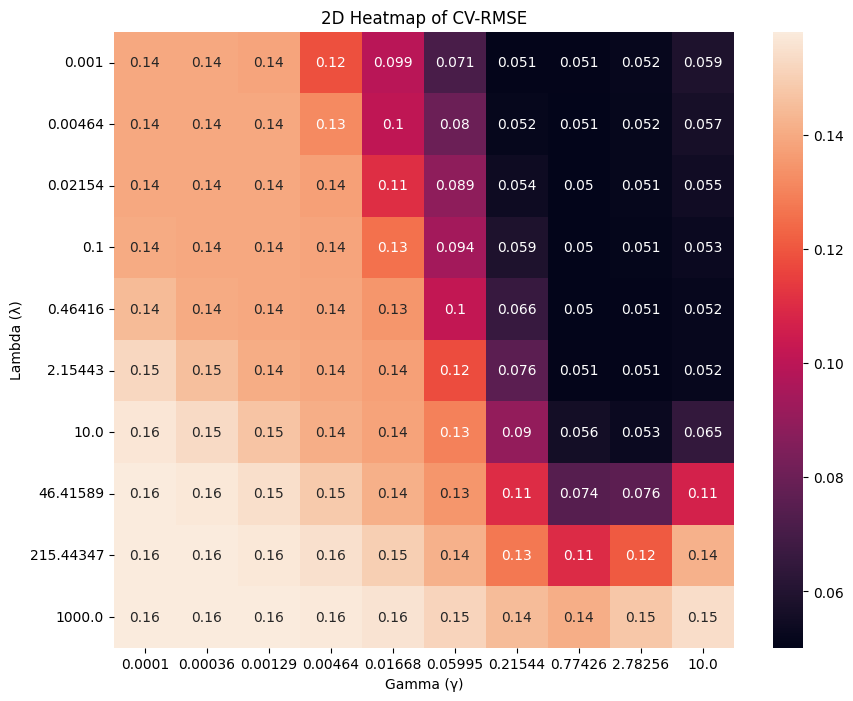

In [33]:
import seaborn as sns

mean_rmses  = []
std_rmses = []

for lam in lambdas:
    for gam in gammas:
        fold_rmses =  RBF_k_cross_validation(X_tr, y_tr, gamma=gam, lamda = lam)
        means_rmse = np.mean(fold_rmses)
        std_rmse = np.std(fold_rmses)
        mean_rmses.append(means_rmse)
        std_rmses.append(std_rmse)

rmse_matrix = np.array(mean_rmses).reshape(len(lambdas), len(gammas))
print(rmse_matrix.shape)
plt.figure(figsize=(10, 8))
sns.heatmap(rmse_matrix, annot=True, xticklabels=np.round(gammas, 5), yticklabels=np.round(lambdas, 5))
plt.xlabel('Gamma (γ)')
plt.ylabel('Lambda (λ)')
plt.title('2D Heatmap of CV-RMSE')
plt.show()


The darker it gets, the lower the RMSE. From the 2D heatmap of CV-RMSE we can conclude that:

- **Lowest RMSE:** **0.05**
- This minimum is reached for several (λ, γ) pairs, including:
  - **λ = 0.02154**, **γ = 0.77426**
  - **λ = 0.1**, **γ = 0.77426**
  - **λ = 0.46416**, **γ = 0.77426**


In [34]:
primal_kernel_ridge = []
ridge_weights = {}

In [35]:
lamda = 0.02154
gamma = 0.77426
K_tr = RBF_kernel_function(X_tr_bias, X_tr_bias, gamma)
        
alpha = np.linalg.solve(K_tr + lamda*np.eye(len(K_tr)), y_tr)
K_val = RBF_kernel_function(X_te_bias, X_tr_bias, gamma=gamma)
y_pred = K_val @ alpha
kernel_ridge = y_pred
kernel_rmse = rmse(y_te , y_pred)


In [36]:


Z_deg3_tr, Z_deg3_te, y_train, y_test = train_test_split(Z_deg3, y, test_size=0.25, random_state=SEED)
lamdas = np.logspace(-8, 3, num=10)
results = []
for lam in lamdas:
    fold_rmses, fold_norms = ten_Cross_validation_for_3(Z_deg3_tr, y_train, lam)    

    avg_ols_rmse = np.mean(fold_rmses)
    results.append((lam, avg_ols_rmse))
    
best_lam = min(results, key=lambda x: x[1])[0]

Z_deg3_tr_bias = np.c_[np.ones((Z_deg3_tr.shape[0],1)), Z_deg3_tr]
Z_deg3_te_bias = np.c_[np.ones((Z_deg3_te.shape[0],1)), Z_deg3_te]

final_weights = solve_normal_equation(Z_deg3_tr_bias, y_train, lam=best_lam)
y_pred = Z_deg3_te_bias @ final_weights
primal_rmse = rmse(y_test , y_pred)


In [37]:
import time
import tracemalloc

n, d = X.shape[0], X.shape[1]
n_train = X_tr.shape[0]
eff_feat_primal = Z_deg3.shape[1]
eff_feat_kernel = n_train

tracemalloc.start()
t0 = time.perf_counter()
t1 = time.perf_counter()
_, peak_primal = tracemalloc.get_traced_memory()
tracemalloc.stop()
time_primal = t1 - t0
mem_primal_mb = peak_primal / (1024 * 1024)

tracemalloc.start()
t0 = time.perf_counter()
t1 = time.perf_counter()
_, peak_kernel = tracemalloc.get_traced_memory()
tracemalloc.stop()
time_kernel = t1 - t0
mem_kernel_mb = peak_kernel / (1024 * 1024)

readings = [
    {'Model': 'Primal ridge', 'n': n, 'd': d, 'Effective features': eff_feat_primal,
     'Final test RMSE': f'{primal_rmse:.4f}', 'Runtime (s)': f'{time_primal:.4f}', 'Memory (MB)': f'{mem_primal_mb:.4f}'},
    {'Model': 'Kernel ridge',  'n': n, 'd': d, 'Effective features': eff_feat_kernel,
     'Final test RMSE': f'{kernel_rmse:.4f}', 'Runtime (s)': f'{time_kernel:.4f}', 'Memory (MB)': f'{mem_kernel_mb:.4f}'},
]
result_df = pd.DataFrame(readings)
result_df.set_index("Model", inplace=True)
print(result_df)

                 n  d  Effective features Final test RMSE Runtime (s)  \
Model                                                                   
Primal ridge  2500  2                   9          0.1042      0.0007   
Kernel ridge  2500  2                1875          0.0508      0.0001   

             Memory (MB)  
Model                     
Primal ridge      0.0202  
Kernel ridge      0.0202  


## Part 4

### 4.1

 **Source:** UCI Machine Learning Repository — Wine Quality Data Set  
  (https://archive.ics.uci.edu/ml/datasets/wine+quality or similar).  
- **Categorical encoding:** Not applicable — all input features are numeric.
- **dataset name:** red wine quality  
- **dataset features:** 11  
- **dataset samples:** 1599  
- **train test split:** 75/25  
- **missing values:** none  


**Scaling strategy:** using  $Xscaled​=X−mean(X) / std(X)​$ to scale both test and trainng data

In [38]:
DATA_PATH = Path("data") / "winequality-red.csv"
SEED = 42

def load_txt_dataset(path: str):

    arr = np.loadtxt(path, delimiter = ';', skiprows=1)
    X, y = arr[:, :-1], arr[:, -1]
    return X, y
X,y = load_txt_dataset(DATA_PATH)


X_tr, X_te, y_tr, y_te  = train_test_split(X, y, test_size=0.25, random_state=SEED)

X_tr_bias, X_te_bias = add_bias(X_tr, X_te)

$X_{scaled}​=X−mean(X) / std(X)​$

In [39]:
mean = np.mean(X_tr)
std = np.std(X_tr)

X_tr_scaled = (X_tr - mean) / std 
X_te_scaled = (X_te - mean) / std 

### 4.2

- In this section we are going to ecaluate the following:
    - OLS
    - ridge regression
    - robust regression
    - kernel ridge

In [40]:
X_tr_scaled_bias = np.c_[np.ones((X_tr_scaled.shape[0],1)), X_tr_scaled]
X_te_scaled_bias = np.c_[np.ones((X_te_scaled.shape[0],1)), X_te_scaled]


#### OLS
$w = (X^T X)^{−1}X^T y$

In [41]:
results_data = []
metrics = {}

ols_rmse, _ = ten_Cross_validation_for_3(X_tr_scaled, y_tr)
avg_ols_rmse = np.mean(ols_rmse)
std_ols_rmse = np.std(ols_rmse)



ols_weights = solve_normal_equation(X_tr_scaled_bias, y_tr)
final_ols_y_hat = X_te_scaled_bias @ ols_weights
final_ols_test_rmse = rmse(y_te, final_ols_y_hat) 
results_data.append({
    "Model": "OLS",
    "CV Score (RMSE)": f"{avg_ols_rmse:.4f} ± {std_ols_rmse:.4f}",
    "Test Score (RMSE)": final_ols_test_rmse
})




#### Ridge Regression

$w=(X^T X+λI)^{−1}X^Ty$

In [42]:
lamdas = np.logspace(-6, 3, num=10)
ridge_result = []
for lam in lamdas:
    ridge_cv_rmse, ridge_cv_norms = ten_Cross_validation_for_3(X_tr_scaled, y_tr, lam=lam)
    
    avg_ridge_rmse = np.mean(ridge_cv_rmse)
    std_ridge_rmse = np.std(ridge_cv_rmse)
    ridge_result.append((lam, avg_ridge_rmse, std_ridge_rmse))


alpha = 0.8

best_result = min(ridge_result, key=lambda x: x[1]+ alpha * x[2]) #checks for lowest rmse then returns lambda
best_lambda = best_result[0]
best_rmse = best_result[1]
best_std = best_result[2]
final_weights = solve_normal_equation(X_tr_scaled_bias, y_tr, lam=best_lambda)
final_ridge_y_hat = X_te_scaled_bias @ final_weights
final_ridge_test_rmse = rmse(y_te, final_ridge_y_hat)

results_data.append({
    "Model": f"Ridge (λ={best_lambda})",
    "CV Score (RMSE)": f"{best_rmse:.4f}±{best_std:.4f}", 
    "Test Score (RMSE)": final_ridge_test_rmse
})


#### Robust Regression

In [43]:
def increment_reduced_least_squares(X, y, w, delta=1.0, tol=1e-6, max_iter=100):
    """
    Iteratively reweighted least squares for Huber regression
    """
    samples, features = X.shape 
    theta = np.linalg.pinv(X.T @ X) @ X.T @ y 
    
    for _ in range(max_iter):
        y_hat  = X @ theta
        residuals = y - y_hat 
        scale = np.median(np.abs(residuals)) / 0.6745
        if scale < 1e-8:
            break
        
        r_std = residuals / scale #standard residuals
        
        w = np.ones(samples)
        mask = np.abs(r_std) > delta
        w[mask] = delta / np.abs(r_std[mask])
        
        Xw = w[:, np.newaxis] * X
        theta_new = np.linalg.pinv(X.T @ Xw) @ (X.T @ (w * y))
        
        if np.linalg.norm(theta_new - theta) < tol:
            break
            
        theta = theta_new
    
    return theta
    

In [44]:
def ten_Cross_validation_for_robust(X, y, delta=1.0):
    fold_rmses, fold_norms = [], []
    
    
    x_split, y_split = split_for_kcv(X, y)
    
    for i in range(len(x_split)):
        x_sub = x_split.copy()
        y_sub = y_split.copy()
        
        X_val = x_sub.pop(i)
        y_val = y_sub.pop(i)
        
        X_train = np.vstack(x_sub)
        y_train = np.hstack(y_sub)
        
        # Add bias term
        X_tr_bias = np.c_[np.ones((X_train.shape[0], 1)), X_train]
        X_val_bias = np.c_[np.ones((X_val.shape[0], 1)), X_val]
        
        #IRLS
        initial_w = np.ones(X_train.shape[0])
        weights = increment_reduced_least_squares(X_tr_bias, y_train, initial_w, delta=delta)
        
        # Predict and evaluate
        y_pred = X_val_bias @ weights
        l2_norm = np.linalg.norm(weights)
        fold_rmses.append(rmse(y_val, y_pred))
        fold_norms.append(l2_norm)
        
    return fold_rmses, fold_norms


In [45]:
deltas = [0.1, 0.3, 0.5, 1.0, 1.35, 2.0, 5.0]
robust_result = []

for delta in deltas:
    robust_rmse, robust_norms = ten_Cross_validation_for_robust(X_tr_scaled, y_tr, delta=delta)
    
    avg_robust_rmse = np.mean(robust_rmse)
    std_robust_rmse = np.std(robust_rmse)
    robust_result.append((delta, avg_robust_rmse, std_robust_rmse))

alpha = 0.8
best_result = min(robust_result, key=lambda x: x[1] + alpha * x[2])
best_delta = best_result[0]
best_rmse = best_result[1]
best_std = best_result[2]




X_tr_scaled_bias = np.c_[np.ones((X_tr_scaled.shape[0], 1)), X_tr_scaled]
X_te_scaled_bias = np.c_[np.ones((X_te_scaled.shape[0], 1)), X_te_scaled]

initial_w = np.ones(X_tr_scaled.shape[0])
final_weights = increment_reduced_least_squares(X_tr_scaled_bias, y_tr, initial_w, delta=best_delta)

final_robust_test_y_hat = X_te_scaled_bias @ final_weights
final_robust_test_rmse = rmse(y_te, final_robust_test_y_hat)



if 'results_data' not in locals():
    results_data = []

results_data.append({
    "Model": f"Robust (δ={best_delta})",
    "CV Score (RMSE)": f"{best_rmse:.4f}±{best_std:.4f}", 
    "Test Score (RMSE)": final_robust_test_rmse
})

#### Kernel Ridge Regression

**Formulas**
- $\alpha=(K + \lambda I)⁻¹y$ insted of solving for weight for every feature, we solve for weight for every data point
- $k(x,x') =exp(−γ∣∣x−x'∣∣^2) $. $\gamma$ this controls the weight of the kernel. RBF formula. We use to get $N \times N$
- $y^​(x)=k(x,X)^⊤α$  the predictor


In [46]:
lambdas, gammas = np.logspace(-3, 1, num=10), np.logspace(-2, 1, num=10) 

In [47]:


RBF_result = []


for lam in lambdas: 
    for gam in gammas:
        fold_rmse = RBF_k_cross_validation(X_tr_scaled, y_tr, gamma=gam, lamda = lam)
        # avg_RBF_rmses.append(means_RBF_rmse)
        
        avg_RBF_rmse = np.mean(fold_rmse)
        std_RBF_rmse = np.std(fold_rmse)
        
        RBF_result.append((lam, gam, avg_RBF_rmse, std_RBF_rmse))

alpha = 0.8
best_result = min(RBF_result, key=lambda x: x[2] + alpha * x[3])
best_lambda = best_result[0]
best_gamma = best_result[1]
best_rmse = best_result[2]
best_std = best_result[3]

X_tr_scaled_bias = np.c_[np.ones((X_tr_scaled.shape[0], 1)), X_tr_scaled]
X_te_scaled_bias = np.c_[np.ones((X_te_scaled.shape[0], 1)), X_te_scaled]

K_tr = RBF_kernel_function(X_tr_scaled_bias, X_tr_scaled_bias, best_gamma)
alpha = np.linalg.solve(K_tr + best_lambda*np.eye(len(K_tr)), y_tr)
K_val = RBF_kernel_function(X_te_scaled_bias, X_tr_scaled_bias, gamma=best_gamma)
y_pred = K_val @ alpha

kernel_rmse = rmse(y_te , y_pred)

results_data.append({
    "Model": f"RBF (γ={best_gamma:.5f}, λ={best_lambda})",
    "CV Score (RMSE)": f"{best_rmse:.4f}±{best_std:.4f}", 
    "Test Score (RMSE)": kernel_rmse
})


In [48]:
print("Table: CV mean ± std (10-fold) and final hold-out test RMSE for each model.")
results_df = pd.DataFrame(results_data)
results_df.set_index("Model", inplace=True)

print(results_df)

Table: CV mean ± std (10-fold) and final hold-out test RMSE for each model.
                          CV Score (RMSE)  Test Score (RMSE)
Model                                                       
OLS                       0.6621 ± 0.0277           0.623139
Ridge (λ=0.0001)            0.6612±0.0273           0.623401
Robust (δ=5.0)              0.6621±0.0277           0.623139
RBF (γ=0.02154, λ=0.001)    0.6567±0.0272           0.621716


### 4.3

In [49]:
def ten_Cross_validation(X, y, lam = 0, p: int = None, seed = SEED):
    fold_rmses,fold_norms = [],[]
    
    x_split, y_split = split_for_kcv(X, y, seed=seed)
    

    for i in range(len(x_split)):
        x_sub = x_split.copy()
        y_sub = y_split.copy()
        
        
        X_val= x_sub.pop(i)
        y_val = y_sub.pop(i)
        
        X_train = np.vstack(x_sub)
        
        y_train = np.hstack(y_sub)
        if p:
            X_train = X_train[:p, :]
            y_train = y_train[:p]
       
        
        X_tr_bias = np.c_[np.ones((X_train.shape[0],1)), X_train]
        X_val_bias = np.c_[np.ones((X_val.shape[0],1)), X_val]
        
        weights = solve_normal_equation(X_tr_bias, y_train, lam = lam)    
        
            
        y_pred = X_val_bias @ weights
        
        l2_norm = np.linalg.norm(weights)
        fold_rmses.append(rmse(y_val, y_pred))
        fold_norms.append(l2_norm)
        
        
    return fold_rmses, fold_norms

In [50]:
train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9]
seeds = [42, 7, 123, 2024, 999]
ols_std, ols_rmses = [], []
ridge_std, ridge_rmses = [], []

X_tr_samples, X_tr_features = X_tr_scaled.shape
for tr_size in train_sizes:
    new_tr_size = int(X_tr_samples * tr_size)
    ols_mean_rmses_this_size = []   # collect mean_rmse for each seed
    ridge_mean_rmses_this_size = []
    
   
    for seed in seeds:
        #ols
        fold_rmse,  _ = ten_Cross_validation(X_tr_scaled, y_tr, p=new_tr_size, seed =seed)
        
        mean_rmse = np.mean(fold_rmse)
        ols_mean_rmses_this_size.append(mean_rmse)
    
        #ridge    
        fold_rmse,  _ = ten_Cross_validation(X_tr_scaled, y_tr,lam=0.001, p=new_tr_size, seed = seed)
        
        
        mean_rmse = np.mean(fold_rmse)
        ridge_mean_rmses_this_size.append(mean_rmse)
        
    ols_rmses.append(np.mean(ols_mean_rmses_this_size))
    ols_std.append(np.std(ols_mean_rmses_this_size))
    ridge_rmses.append(np.mean(ridge_mean_rmses_this_size))
    ridge_std.append(np.std(ridge_mean_rmses_this_size))






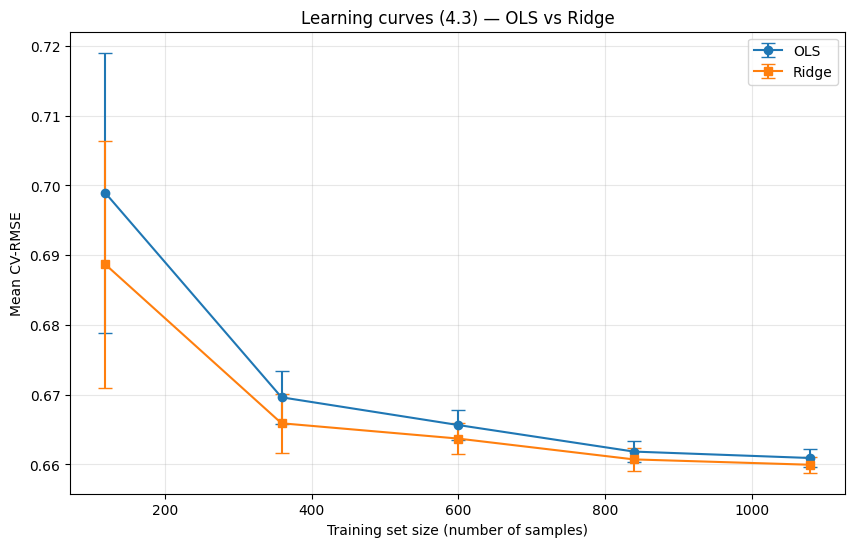

In [51]:
sample_counts = [int(X_tr_samples * t) for t in train_sizes]

plt.figure(figsize=(10, 6))
plt.errorbar(sample_counts, ols_rmses, yerr=ols_std, label='OLS', fmt='-o', capsize=5)
plt.errorbar(sample_counts, ridge_rmses, yerr=ridge_std, label='Ridge', fmt='-s', capsize=5)
plt.xlabel('Training set size (number of samples)')
plt.ylabel('Mean CV-RMSE')
plt.title('Learning curves (4.3) — OLS vs Ridge')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


**Variance estimate:** The error bars on the learning curves are the standard deviation of mean CV-RMSE across 5 different random seeds (repeated 10-fold CV). This gives a variance estimate for each training set size.